In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import sys 
sys.path.insert(0, '../src/')
import jsm_mcmc
import jsm_SHMR

import warnings; warnings.simplefilter('ignore')

selecting a paramtrization of the SHMR and reading in the data

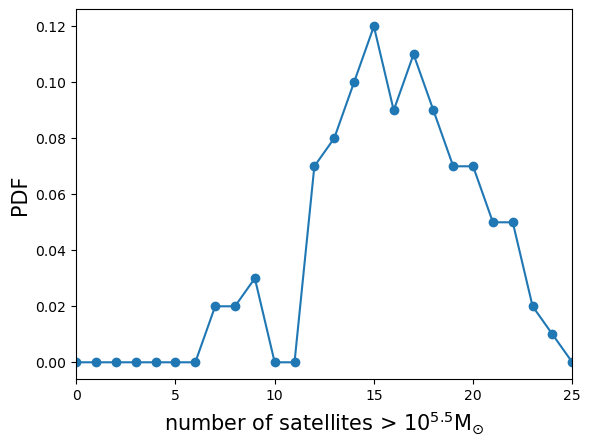

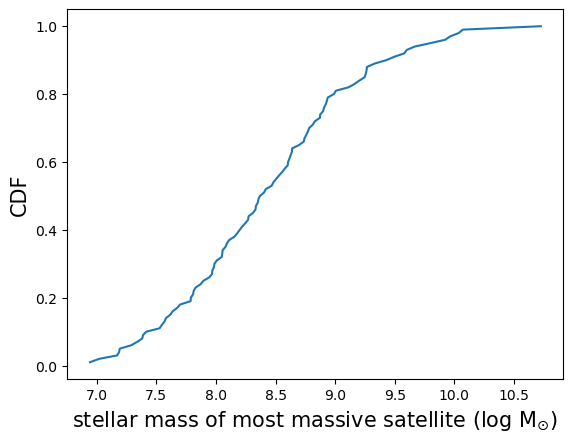

In [16]:
fid_theta = [1.8, -0.2, 0.4]
priors = [[-5, 5],[-3, 1],[0, 5]]
params = ["a_1", "a_2", "a_3"]


data = jsm_mcmc.mock_data(fid_theta, jsm_SHMR.sigma, 0, "../../data/MW-analog/meta_data_psi3/jsm_MCMC.npy")
data.get_stats(min_mass=5.5)

defining the foward model(s). They don't include the SAGA index selected as "data"

In [17]:
def forward(theta):
    models = jsm_mcmc.models(theta, jsm_SHMR.sigma, data.lgMh_models)
    models.get_stats(min_mass=5.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

defining the log likelyhood

In [18]:
def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and priors[1][0] < theta[1] < priors[1][1] and priors[2][0] < theta[2] < priors[2][1]:
        return 0.0
    else:
        return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

intializing the run!

In [19]:
nwalk = 100
nsteps = 100
ndim = len(fid_theta)
start_theta = [1.4, -0.3, 1] # a somewhat random starting place

RUNNING!

In [20]:
mcmc_out = jsm_mcmc.RUN(start_theta, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim)

Run took 788.5 seconds


In [21]:
datadir="../../data/MCMC/minmass/"

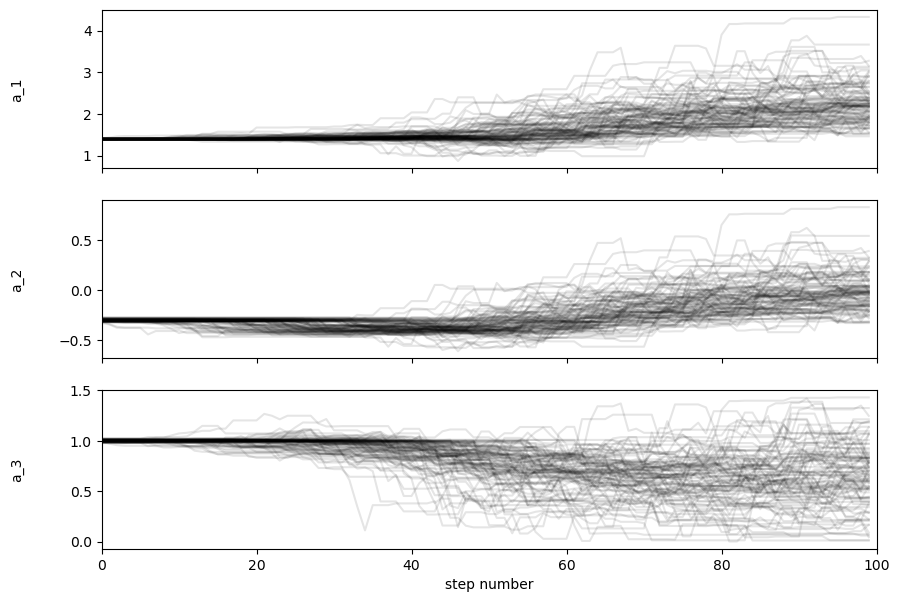

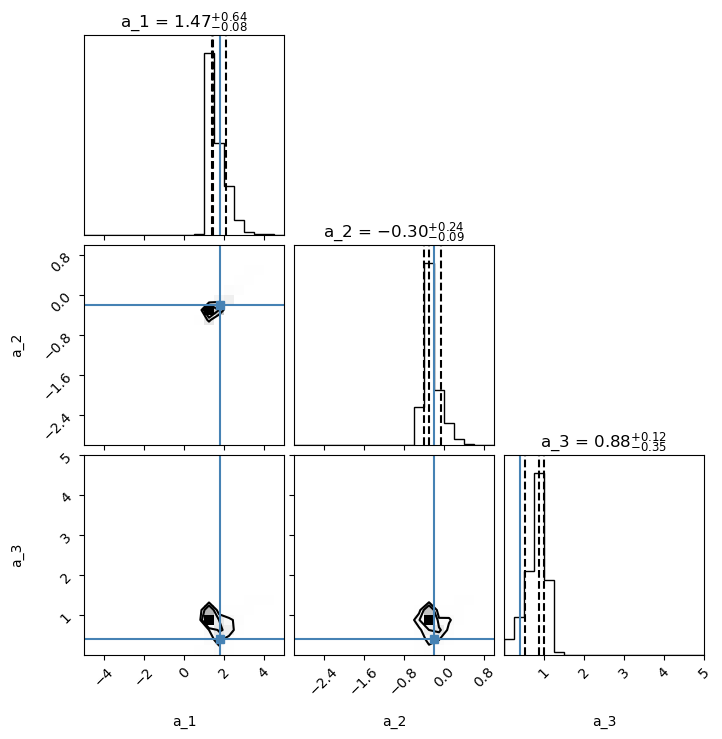

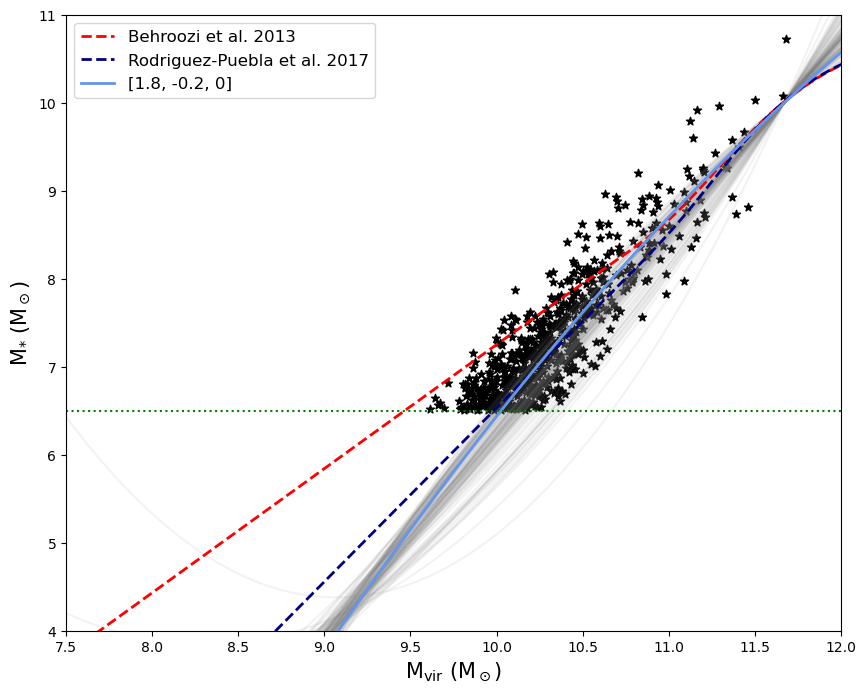

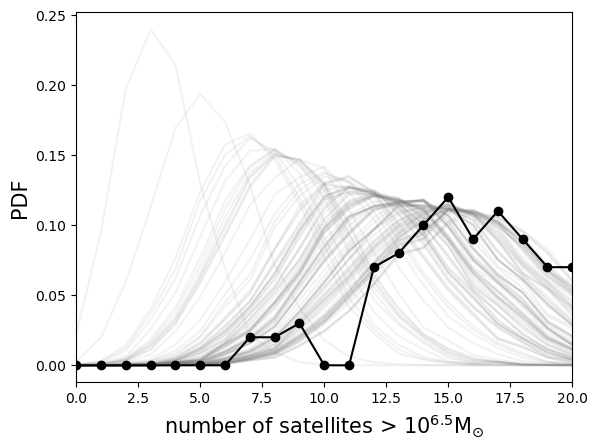

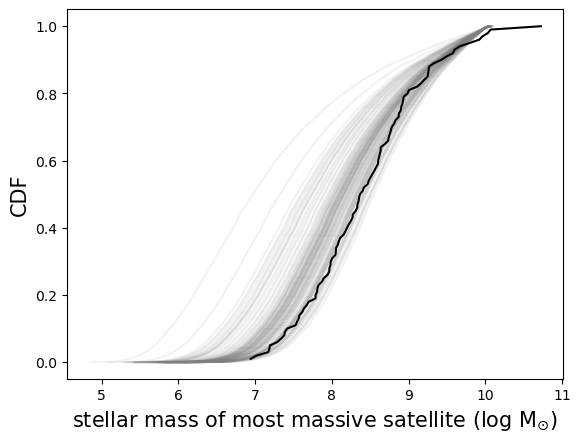

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
run = jsm_mcmc.inspect_run(mcmc_out, fid_theta=data.fid_theta, labels=params, priors=priors, savedir=datadir, data=data, SHMR=jsm_SHMR.sigma, forward=forward)